# 0. 구글 드라이브와 연결 및 각종 라이브러리 설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 54.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 데이터 로드

### 데이터 로드 및 최종 점검

In [ ]:
data = pd.read_excel('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/final_data.xlsx', engine='openpyxl')

In [ ]:
data.head(2)

,Unnamed: 0,document,label
0,0,어릴 때 보고 지금 다시 봐도 재밌어ㅋㅋ,1
1,1,디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1


In [ ]:
data['document'].shape[0], data['document'].nunique()

(303475, 293106)

In [ ]:
data = data.drop_duplicates(subset=['document'], ignore_index=True)

In [ ]:
data['document'].shape[0], data['document'].nunique()

(293106, 293106)

In [ ]:
data = data[['document', 'label']]

In [ ]:
data

,document,label
0,어릴 때 보고 지금 다시 봐도 재밌어ㅋㅋ,1
1,디자인을 배우는 학생으로 외국 디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...,1
2,폴리스 스토리 시리즈는부터 뉴까지 버릴게 하나도 없음 최고,1
3,와 연기가 진짜 개쩔구나 지루할 거라고 생각했는데 몰입해서 봤다 그래 이런 게 진짜...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
...,...,...
293101,내가 게을러서 다른 방법을 아직 생각하진 못했어,0
293102,댄스 동호회는 좀 괜찮은 것 같은데 이참에 가입해볼까,0
293103,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
293104,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0


# 2. 학습용 데이터와 테스트용 데이터 나누기

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
train_data.shape, test_data.shape

((219829, 2), (73277, 2))

In [ ]:
train_data

,document,label
13946,만 점짜리 한국 최고의 코미디 영화,1
255599,다들 새로운 친구를 잘 사귀는데 나만 아무도 만나지 못하는 것 같아,0
240953,전에 잘못했을 때에는 격려해주셨는데 이번에는 작은 실수로 이러시니 어떻게 받아들여야...,0
265024,딸들한테 전화하고 싶은데 용기가 나질 않네,0
26781,가히 최고의 시리즈라 할 수 있다,1
...,...,...
119879,자아에 대한 해묵은 고찰마저 방해하는 단조로운 진행,0
259178,대화가 뭐야,0
131932,말이 필요 없다 ㅡ명작ㅡ,1
146867,편식이가 좀 줬다 그냥 닥치고 보란다,1


In [ ]:
print("train_data 클래스별 샘플 개수:\n",
     {n: v for n, v in zip([0, 1], np.bincount(train_data['label']))}, '긍정의 비율:', train_data['label'].sum()/train_data.shape[0]) 
print("test_data 클래스별 샘플 개수:\n",
     {n: v for n, v in zip([0, 1], np.bincount(test_data['label']))}, '긍정의 비율:', test_data['label'].sum()/test_data.shape[0]) 

# 잘 나눠진 것을 볼 수 있다.

train_data 클래스별 샘플 개수:
 {0: 136435, 1: 83394} 긍정의 비율: 0.37935850138061855
test_data 클래스별 샘플 개수:
 {0: 45501, 1: 27776} 긍정의 비율: 0.37905481938398133


# 3. 토큰화

In [ ]:
stopwords = ['ㅋ', 'ㅎ', 'ㅠ', 'ㅉ', 'ㅡ']

In [ ]:
okt = Okt()

In [ ]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.pos(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word, pos in tokenized_sentence if (not word in stopwords) and (not pos in ['Josa', 'Eomi', 'PreEomi', 'Suffix'])] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 219829/219829 [05:43<00:00, 639.41it/s]


In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.pos(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word, pos in tokenized_sentence if (not word in stopwords) and (not pos in ['Josa', 'Eomi', 'PreEomi', 'Suffix'])] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 73277/73277 [01:46<00:00, 689.23it/s]


In [ ]:
X_train[:10]

[['만', '점', '짜다', '한국', '최고', '코미디', '영화'],
 ['다', '들다', '새롭다', '친구', '자다', '사귀다', '나', '아무', '만나다', '못', '하다', '것', '같다'],
 ['전',
  '잘',
  '못',
  '하다',
  '때',
  '격려',
  '해주다',
  '이번',
  '작다',
  '실수',
  '이',
  '러시',
  '어떻다',
  '받아들이다',
  '하다',
  '모르다'],
 ['딸', '전화하다', '싶다', '용기', '나다', '않다'],
 ['가히', '최고', '시리즈', '하다', '수', '있다'],
 ['너무', '영화', '허다', '술', '허다', '접'],
 ['확실하다', '뭔가', '좀', '어색하다', '제시카', '알바', '연기'],
 ['투사부일체', '다른', '재미', '있다', '특히', '주인공', '표정', '연기', '일품'],
 ['액션',
  '쓰리다',
  '로맨스',
  '리얼리티',
  '모든',
  '것',
  '갖추다',
  '최고',
  '영화',
  '이다',
  '마지막',
  '열리다',
  '결말',
  '정말',
  '좋다',
  '점',
  '만점',
  '점'],
 ['내', '평생', '가장', '좋아하다', '영화', '잊다', '수가', '없다']]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
len(tokenizer.word_index)

38543

In [ ]:
tokenizer.word_index  

{'하다': 1,
 '영화': 2,
 '보다': 3,
 '있다': 4,
 '없다': 5,
 '너무': 6,
 '것': 7,
 '이': 8,
 '내': 9,
 '같다': 10,
 '좋다': 11,
 '나': 12,
 '안': 13,
 '되다': 14,
 '않다': 15,
 '정말': 16,
 '거': 17,
 '재밌다': 18,
 '못': 19,
 '아니다': 20,
 '말': 21,
 '친구': 22,
 '수': 23,
 '이다': 24,
 '사람': 25,
 '생각': 26,
 '싶다': 27,
 '진짜': 28,
 'ㅋㅋ': 29,
 '나오다': 30,
 '자다': 31,
 '더': 32,
 '다': 33,
 '게': 34,
 '보고': 35,
 '그': 36,
 '때': 37,
 '만들다': 38,
 '이렇다': 39,
 '점': 40,
 '들다': 41,
 '왜': 42,
 '연기': 43,
 '모르다': 44,
 '평점': 45,
 '가다': 46,
 '그렇다': 47,
 '나다': 48,
 '최고': 49,
 '좀': 50,
 '스토리': 51,
 '받다': 52,
 '그냥': 53,
 '돈': 54,
 '주다': 55,
 '돼다': 56,
 '드라마': 57,
 '시간': 58,
 '감동': 59,
 '뭐': 60,
 '볼': 61,
 '오다': 62,
 '아깝다': 63,
 '듯': 64,
 '걸': 65,
 '많이': 66,
 '내용': 67,
 '일': 68,
 '배우': 69,
 '중': 70,
 '많다': 71,
 '하나': 72,
 '재미있다': 73,
 'ㅠㅠ': 74,
 '감독': 75,
 '때문': 76,
 '어떻다': 77,
 '지금': 78,
 '알다': 79,
 '재미없다': 80,
 '줄': 81,
 '이렇게': 82,
 '마음': 83,
 '지루하다': 84,
 '쓰레기': 85,
 '재미': 86,
 '사랑': 87,
 '먹다': 88,
 '건': 89,
 '다시': 90,
 '전': 91,
 '요즘': 92,
 '우리'

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 38543
등장 빈도가 2번 이하인 희귀 단어의 수: 18717
단어 집합에서 희귀 단어의 비율: 48.56134706691228
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0859015167259198


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19827


In [ ]:
tokenizer = Tokenizer(vocab_size) #	the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[0])

[140, 40, 367, 157, 49, 237, 2]


In [ ]:
reversed = {n:w for w, n in tokenizer.word_index.items()} 

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

# 빈 샘플들을 제거
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

219666
219666
73186
73186


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 66
리뷰의 평균 길이 : 9.728624366083054


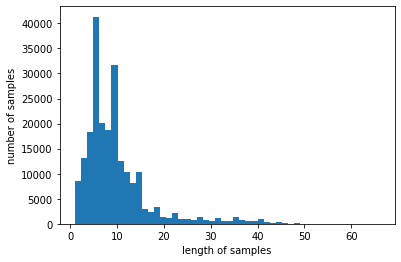

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.58253894548997


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
X_train

array([[   0,    0,    0, ...,   49,  237,    2],
       [   0,    0,    0, ...,    1,    7,   10],
       [   0,    0,    0, ..., 1924,    1,   44],
       ...,
       [   0,    0,    0, ...,  346,    5,  167],
       [   0,    0,    0, ...,   53, 3271,    3],
       [   0,    0,    0, ..., 4240,   32,   73]], dtype=int32)

In [ ]:
np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/X_train.npy', X_train)
np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/X_test.npy', X_test)

np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/y_train.npy', y_train)
np.save('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/y_test.npy', y_test)

# 여기서부터 시작하면 된다.

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/X_train.npy', allow_pickle=True)
X_test = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/X_test.npy', allow_pickle=True)

y_train = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/y_train.npy', allow_pickle=True)
y_test = np.load('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/y_test.npy', allow_pickle=True)

In [ ]:
X_train.shape

(219666, 30)

In [ ]:
X_test.shape

(73186, 30)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/best_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2743/2746 [============================>.] - ETA: 0s - loss: 0.3779 - acc: 0.8339
Epoch 1: val_acc improved from -inf to 0.85460, saving model to /content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/best_lstm_model.h5
2746/2746 [==============================] - 33s 9ms/step - loss: 0.3779 - acc: 0.8338 - val_loss: 0.3373 - val_acc: 0.8546
Epoch 2/15
2743/2746 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.8635
Epoch 2: val_acc improved from 0.85460 to 0.86186, saving model to /content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/best_lstm_model.h5
2746/2746 [==============================] - 24s 9ms/step - loss: 0.3218 - acc: 0.8635 - val_loss: 0.3226 - val_acc: 0.8619
Epoch 3/15
2741/2746 [============================>.] - ETA: 0s - loss: 0.2986 - acc: 0.8760
Epoch 3: val_acc improved from 0.86186 to 0.86584, saving model to /content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최ᄌ

# 모델을 여기서부터

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('/content/gdrive/MyDrive/CUAI 하계 컨퍼런스 프로젝트/data preprocessing 최종/best_lstm_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2288/2288 [==============================] - 32s 13ms/step - loss: 0.3158 - acc: 0.8675

 테스트 정확도: 0.8675
